# **Education Project:** How well do socioeconomic variables and student-teacher ratio predict ACT performance?

### Introduction

This project aims to explore what variables, if any, are good for estimating ACT score performance among high schools across the United States. The goal of the modeling phase is to build a predictive model for ACT scores based on socioeconomic variables and student-teacher ratio, and to evaluate its accuracy.

Data Sources: 
* [edGap](https://www.edgap.org/#5/37.875/-96.987) - This data set from 2016 includes information about average ACT or SAT scores for schools and several socioeconomic characteristics of the school district.
* [NCES](https://nces.ed.gov/ccd/pubschuniv.asp) - The secondary data set is basic information about each school from the National Center for Education Statistics.
* [NCES ELSi table generator](https://nces.ed.gov/ccd/elsi/default.aspx?agree=0) - The third data set also comes from the National Center for Education Statistics and was generated using the Elementary and Secondary Information System, and contains student-teacher ratio data from over 9,000 schools.

## Data Processing

### Import Libraries

In [874]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns

# set the plotting style
sns.set_style("whitegrid")

# Import libraries for statistical modeling
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.metrics import *
from statsmodels.stats.anova import anova_lm


### Load Data

#### Load and inspect the school information data

##### Load the school information data

In [778]:
import requests

url = "https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=1"
r = requests.get(url)
open("ccd_sch_029_1617_w_1a_11212017.csv", "wb").write(r.content)

40477083

In [779]:
school_information = pd.read_csv(
    "ccd_sch_029_1617_w_1a_11212017.csv", encoding="unicode_escape"
)

/var/folders/xt/nxv5zlb16l3d5frh__9xjzy80000gn/T/ipykernel_57666/2591098979.py:1: DtypeWarning:

Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.



##### Examine the first 5 rows

In [780]:
school_information.head()

,SCHOOL_YEAR,FIPST,STATENAME,ST,SCH_NAME,LEA_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,...,G_10_OFFERED,G_11_OFFERED,G_12_OFFERED,G_13_OFFERED,G_UG_OFFERED,G_AE_OFFERED,GSLO,GSHI,LEVEL,IGOFFERED
0,2016-2017,1,ALABAMA,AL,Sequoyah Sch - Chalkville Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
1,2016-2017,1,ALABAMA,AL,Camps,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
2,2016-2017,1,ALABAMA,AL,Det Ctr,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
3,2016-2017,1,ALABAMA,AL,Wallace Sch - Mt Meigs Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
4,2016-2017,1,ALABAMA,AL,McNeel Sch - Vacca Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported


##### View information about the data set

In [781]:
school_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SCHOOL_YEAR          102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  NCESSCH              102181 non-null  float64
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

**Note:** there are no null values. It looks like the ID columns are integer or float types. We will want to convert those to an object.

#### Inspect the ACT data

##### Load the edGap data

In [782]:
edgap = pd.read_excel('https://raw.githubusercontent.com/mcsilver99/education/main/data/EdGap_data.xlsx', engine ='openpyxl', dtype={'NCESSCH Schhool ID': object})


/Users/mayasilver/Applications/anaconda3/lib/python3.13/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning:

Unknown extension is not supported and will be removed



##### Examine the first 5 rows of the data set

In [783]:
edgap.head()

,NCESSCH School ID,CT Unemployment Rate,CT Pct Adults with College Degree,CT Pct Childre In Married Couple Family,CT Median Household Income,School ACT average (or equivalent if SAT score),School Pct Free and Reduced Lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


##### View information about the data set

In [784]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   int64  
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB


**Note:** Looks like there are some null values that we might have to impute or remove.

#### Inspect the student-teacher ratio data

##### Load the student-teacher ratio data

In [785]:
student_teacher = pd.read_csv(
    'https://raw.githubusercontent.com/mcsilver99/education/main/data/ELSI_csv_export.csv',
    encoding='latin1'
)

##### Examine the first 5 rows of the data set

In [786]:
student_teacher.head()

,School Name,State Name [Public School] Latest available year,State Abbr,School Name [Public School] 2016-17,School ID (7-digit) Ð NCES Assigned [Public School] 2016-17,NCESSCH,Total Students All Grades (Excludes AE) [Public School] 2016-17,Total Students All Grades (Includes AE) [Public School] 2016-17,Pupil_Teacher_Ratio,Full-Time Equivalent (FTE) Teachers [Public School] 2016-17,School Type [Public School] 2016-17,Grade 9 offered [Public School] 2016-17,Grade 10 offered [Public School] 2016-17,Grade 11 offered [Public School] 2016-17,Grade 12 offered [Public School] 2016-17
0,1 LT CHARLES W. WHITCOMB SCHOOL,Massachusetts,MA,1 LT Charles W. Whitcomb School,2502639,250732002639,1285,1285,11.22,114.49,1-Regular school,2-No,2-No,2-No,2-No
1,100 ACADEMY OF ENGINEERING AND TECHNOLOGY ES,Nevada,NV,Imagine 100 Academy of Excellence,3200670,320006000670,383,383,21.28,18.00,1-Regular school,2-No,2-No,2-No,2-No
2,100 ACADEMY OF ENGINEERING AND TECHNOLOGY MS,Nevada,NV,Imagine 100 Academy of Excellence,3200756,320006000756,118,118,39.33,3.00,1-Regular school,2-No,2-No,2-No,2-No
3,10TH STREET SCHOOL,Washington,WA,10th Street School,5302475,530486002475,181,181,24.79,7.30,1-Regular school,2-No,2-No,2-No,2-No
4,112 ALC MIDDLE SCHOOL,Minnesota,MN,112 ALC MIDDLE SCHOOL,2704622,270819004622,386,386,742.31,0.52,4-Alternative Education School,2-No,2-No,2-No,2-No


##### View information about the data set

In [787]:
student_teacher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93470 entries, 0 to 93469
Data columns (total 15 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   School Name                                                      93470 non-null  object 
 1   State Name [Public School] Latest available year                 93470 non-null  object 
 2   State Abbr                                                       93470 non-null  object 
 3   School Name [Public School] 2016-17                              93470 non-null  object 
 4   School ID (7-digit) Ð NCES Assigned [Public School] 2016-17      93470 non-null  int64  
 5   NCESSCH                                                          93470 non-null  int64  
 6   Total Students All Grades (Excludes AE) [Public School] 2016-17  93470 non-null  int64  
 7   Total Students All Grades (Includes AE) 

**Note:** We now have data on student-teacher ratio. It contains the NCESSCH ID column so we should be able to join all three data sets. 

**Summary**: The school data set and student-teacher ratio data set is a lot larger than the EdGap data. There is data ~22,000 more schools in the school data than the EdGap data. The data is in tidy format for all three data sets. The data types for the variables of interest look correct, but the school identifier is a float/integer in all three data sets. We will want to convert them to an object so we can join them later. 

### Data Preparation

#### Select relevant subsets of the data

##### School information data

In [791]:
school_information = school_information[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
]

##### Student-teacher ratio data

In [792]:
student_teacher = student_teacher[
    ['NCESSCH', 'Pupil_Teacher_Ratio']
]

**Note:** We now have subsets of the relevant information from the school information and student-teacher ratio data.

#### Rename columns of the data frames to follow best practices

In [793]:
edgap = edgap.rename(
    columns={
        "NCESSCH School ID": "id",
        "CT Pct Adults with College Degree": "percent_college",
        "CT Unemployment Rate": "rate_unemployment",
        "CT Pct Childre In Married Couple Family": "percent_married",
        "CT Median Household Income": "median_income",
        "School ACT average (or equivalent if SAT score)": "average_act",
        "School Pct Free and Reduced Lunch": "percent_lunch",
    }
)

In [794]:
school_information = school_information.rename(
    columns={
        "SCHOOL_YEAR": "year",
        "NCESSCH": "id",
        "LSTATE": "state",
        "LZIP": "zip_code",
        "SCH_TYPE_TEXT": "school_type",
        "LEVEL": "school_level",
        "CHARTER_TEXT": "charter"
    }
)

In [795]:
student_teacher=student_teacher.rename(
    columns={
        "NCESSCH": "id", 
        "Pupil_Teacher_Ratio": "student_teacher_ratio",
    }
)

**Summary:** We selected a subset of columns of the school information data set. We renamed the columns for clarity and to follow formatting guidelines. We are ready to join the data frames.

### Join the Data Frames

##### Change the ID columns to an object in the school information, student-teacher ratio, and edGap data so we can merge on the `id` column.

In [796]:
school_information['id'] = school_information['id'].astype('object')

In [797]:
student_teacher['id'] = student_teacher['id'].astype('object')

In [798]:
edgap['id'] = edgap['id'].astype('object')

#### Join the data frames and call the result df. Use a left join on ID as the key.

##### First join the school information and edGap data frames

In [799]:
df = edgap.merge(school_information, how='left', on='id')

In [800]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   object 
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
 7   year               7898 non-null   object 
 8   state              7898 non-null   object 
 9   zip_code           7898 non-null   object 
 10  school_type        7898 non-null   object 
 11  school_level       7898 non-null   object 
 12  charter            7898 non-null   object 
dtypes: float64(6), object(7)
memory usage: 811.2+ KB


##### Then we will join the student-teacher ratio data

In [801]:
df = df.merge(student_teacher, how='left', on='id')

In [802]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7986 non-null   object 
 1   rate_unemployment      7972 non-null   float64
 2   percent_college        7973 non-null   float64
 3   percent_married        7961 non-null   float64
 4   median_income          7966 non-null   float64
 5   average_act            7986 non-null   float64
 6   percent_lunch          7986 non-null   float64
 7   year                   7898 non-null   object 
 8   state                  7898 non-null   object 
 9   zip_code               7898 non-null   object 
 10  school_type            7898 non-null   object 
 11  school_level           7898 non-null   object 
 12  charter                7898 non-null   object 
 13  student_teacher_ratio  7846 non-null   float64
dtypes: float64(7), object(7)
memory usage: 873.6+ KB


**Summary:** We joined the data sets using the school ID as they key. We first cast the ID as an object to have the same data type for the key in each data set. We used a left join to keep all EdGap data because it has the response variable of interest: ACT score.

#### Quality Control

#### Compute descriptive statistics

In [803]:
df.describe()

,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,student_teacher_ratio
count,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000,7846.000000
mean,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651,17.106326
std,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754,74.519133
min,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545,3.860000
25%,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501,13.480000
50%,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570,15.820000
75%,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447,18.360000
max,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729,6592.000000


**Note:** The mean and percentile values for student-teacher ratio seem to be reasonable, however the min and max seem unusually low and high, respectively. We will probably want to drop rows that are out of a reasonable range. We can also see out-of-range values for average ACT and percent lunch that we will want to identify so we can either drop them (in the case of ACT score) or impute them like for percent lunch. 

### Identify missing values

#### Set out-of-range values to `NaN` using `np.nan`.

In [804]:
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan

In [805]:
df.loc[df['average_act'] < 1, 'average_act'] = np.nan

##### Check the types, levels, and charter status of schools

In [806]:
df['school_type'].value_counts()

school_type
Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: count, dtype: int64

In [807]:
df['school_level'].value_counts()

school_level
High            7230
Other            631
Not reported      35
Elementary         2
Name: count, dtype: int64

##### Keep only high schools

In [808]:
df = df.loc[df['school_level'] == 'High']

##### Check for duplicated rows

In [809]:
df.duplicated().sum()

np.int64(0)

**Note:** It is possible that there are incorrectly recorded values in the data set, but we will not go that far in this example.

##### What percentage of values of each variable are missing?

In [811]:
percent_missing = df.isna().mean().round(4) * 100

percent_missing.to_frame(name='Percent Missing Values')

,Percent Missing Values
id,0.00
rate_unemployment,0.17
percent_college,0.15
percent_married,0.28
median_income,0.22
average_act,0.04
percent_lunch,0.28
year,0.00
state,0.00
zip_code,0.00


**Note:** We do have missing values but they are all less than 1% of their respective category. For our predictor variables, we will want to impute missing values later.

#### Create a map showing which states are represented in the data

In [896]:
import plotly.offline as po
import plotly.graph_objs as pg

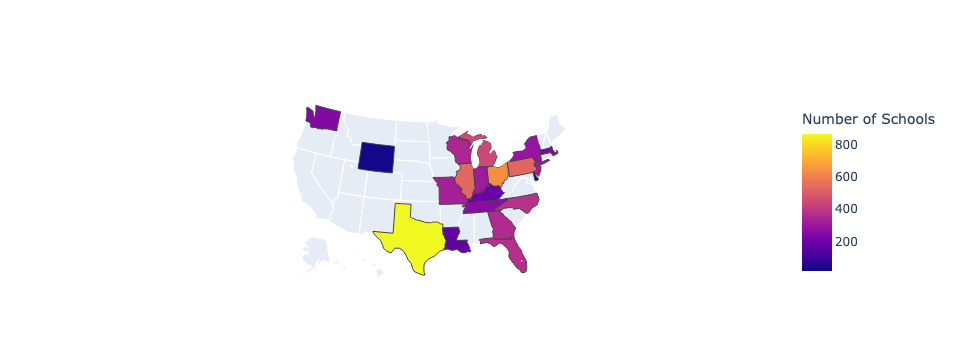

In [897]:
layout = dict(
    geo={"scope": "usa"}, coloraxis_colorbar=dict(title="Number of Schools")
)

data = dict(
    type="choropleth",
    locations=df["state"].value_counts().index,
    locationmode="USA-states",
    z=df["state"].value_counts().values,
    coloraxis="coloraxis",
)

x = pg.Figure(data=[data], layout=layout)

po.iplot(x)

**Note:** The dataset is geographically limited, with Texas schools comprising the majority of observations. Consequently, the model may not be representative of national patterns due to the absence or underrepresentation of many states.

#### Drop the rows where the average ACT score is missing

In [815]:
df = df.dropna(subset=['average_act'])

**Note:** If we drop rows that have `NaNs` for any socioeconomic variables, then we will negatively affect our analysis using the variables where data were present. So, we will not drop the rows in this data set that are missing the socioeconomic variables. We will impute the missing values.

### Impute the NaN values and export the the clean data set

##### Define the predictor variables to be `rate_unemployment`, `percent_college`, `percent_married`, `median_income`, `percent_lunch`, `state`,`charter`, and `student_teacher_ratio`.

In [817]:
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter',
    'student_teacher_ratio'
]

##### Use the iterative imputer to replace missing values in the columns corresponding to predictor variables in the analysis.

In [818]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [819]:
imputer = IterativeImputer()

##### Fit the imputer using the numerical predictor 

Define the columns you want to use in the imputation process

In [820]:
numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

print(numerical_predictors)

['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'student_teacher_ratio']


##### Fit the imputer

In [821]:
imputer.fit(df.loc[:, numerical_predictors])

IterativeImputer()

##### Impute the missing values in the training data.

In [822]:
df.loc[:, numerical_predictors] = imputer.transform(df.loc[:, numerical_predictors])

##### Check for missing values

In [823]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
average_act,0
percent_lunch,0
year,0
state,0
zip_code,0


##### Export the clean data set

In [825]:
df.to_csv(
    'education_clean.csv',
    encoding='utf-8-sig',
    index=False
)

**Summary:**
1. We used an interative imputer to estimate missing values of numerical predictor variables

2. We saved the clean data frame as a csv file.

## Exploratory Data Analysis

### Quality Control: Identify outliers

We can use the interquartile range to identify outliers. This is also evident in boxplots of the data. Median income is on a very different scale than the other predictors, so we wil make two plots to explore the data. 

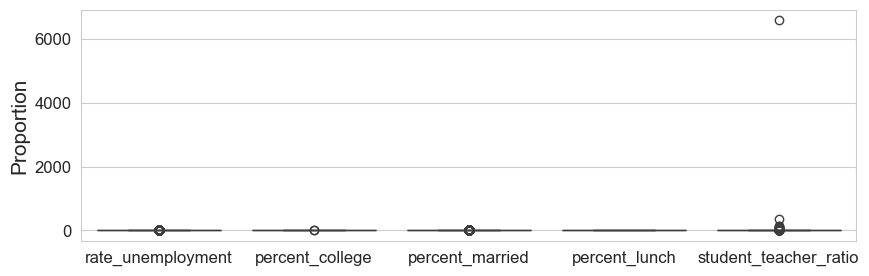

In [829]:
plt.figure(figsize=(10,3))

fractions = list(numerical_predictors)
fractions.remove('median_income')

sns.boxplot(data=df[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.tick_params(labelsize=12)

plt.show()

**Note:** Most notably, the student-teater ratio variable has a really extreme outlier. We will address this later.

#### Look at the box plot of the median income variable 

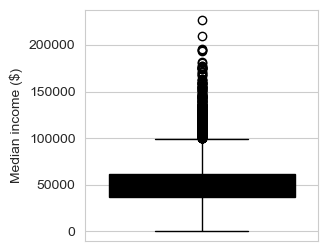

In [830]:
plt.figure(figsize=(3,3))
sns.boxplot(data=df, y='median_income', color='k')
plt.ylabel('Median income ($)')

plt.show()

There are quite a few outliers but that is expected in income data. We should be mindful of the outliers but they do not look incorrect. 

#### Examine the Student-Teacher Ratio values and remove extreme values

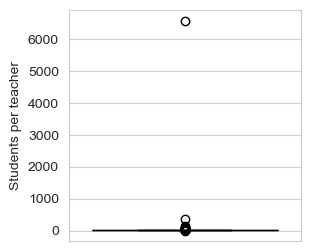

In [831]:
plt.figure(figsize=(3,3))
sns.boxplot(data=df, y='student_teacher_ratio', color='k')
plt.ylabel('Students per teacher')

plt.show()

##### Zoom in on the box plot

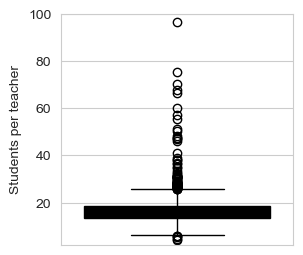

In [832]:
plt.figure(figsize=(3,3))
sns.boxplot(data=df, y='student_teacher_ratio', color='k')
plt.ylabel('Students per teacher')

plt.ylim(2,100)

plt.show()

**Note:** According to the National Center for Education Statistics, the national student-teacher ratio in 2021 is 15.4. Thus it seems reasonable to filter out the extreme cases student-teacher ratios. We will calculate the 1st and 99th percentiles and only keep values that fall within that range. 

##### Filter out extreme student-teacher ratio values keeping the middle 98% and plot the results

In [847]:
lower = df['student_teacher_ratio'].quantile(0.01)
upper = df['student_teacher_ratio'].quantile(0.99)
df = df[(df['student_teacher_ratio'] >= lower) & 
                 (df['student_teacher_ratio'] <= upper)]

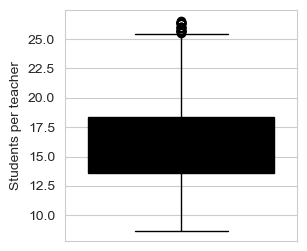

In [848]:
plt.figure(figsize=(3,3))
sns.boxplot(data=df_filtered1, y='student_teacher_ratio', color='k')
plt.ylabel('Students per teacher')

plt.show()

##### Check the min and max values

In [849]:
df['student_teacher_ratio'].agg(['min', 'max'])

min     9.48
max    24.31
Name: student_teacher_ratio, dtype: float64

**Note:** By using the 1st and 99th percentiles, we preserve most of the data while removing extreme outliers. This seems like a much more reasonable spread of student-teacher ratios. 

**Summary:**
* There are outliers in rate_unemployment, percent_college, percent_married, median_income, and student_teacher_ratio. None of these are obviously incorrect values except for student_teacher_ratio.
* Using the 1st and 99th percentiles, only the middle 98% values were retained in the data frame

### Examine distributions and relationships
Plot the correlation matrix of the numerical variables in the training data to explore relationships between the variables.

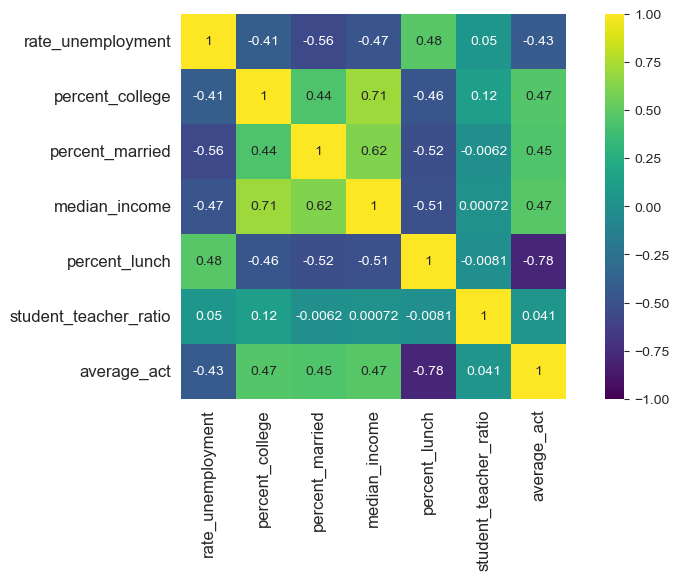

In [850]:
predictor_variables = ["rate_unemployment", "percent_college", "percent_married",
 "median_income", "percent_lunch","student_teacher_ratio"]

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(10,5))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

**Note:** We can see that there is strong correlation between the percentage of students who qualify for a discounted lunch program. Not only are the predictor variables associated with ACT score but also with each other. 

#### Make pair plots to explore relationships between the variables

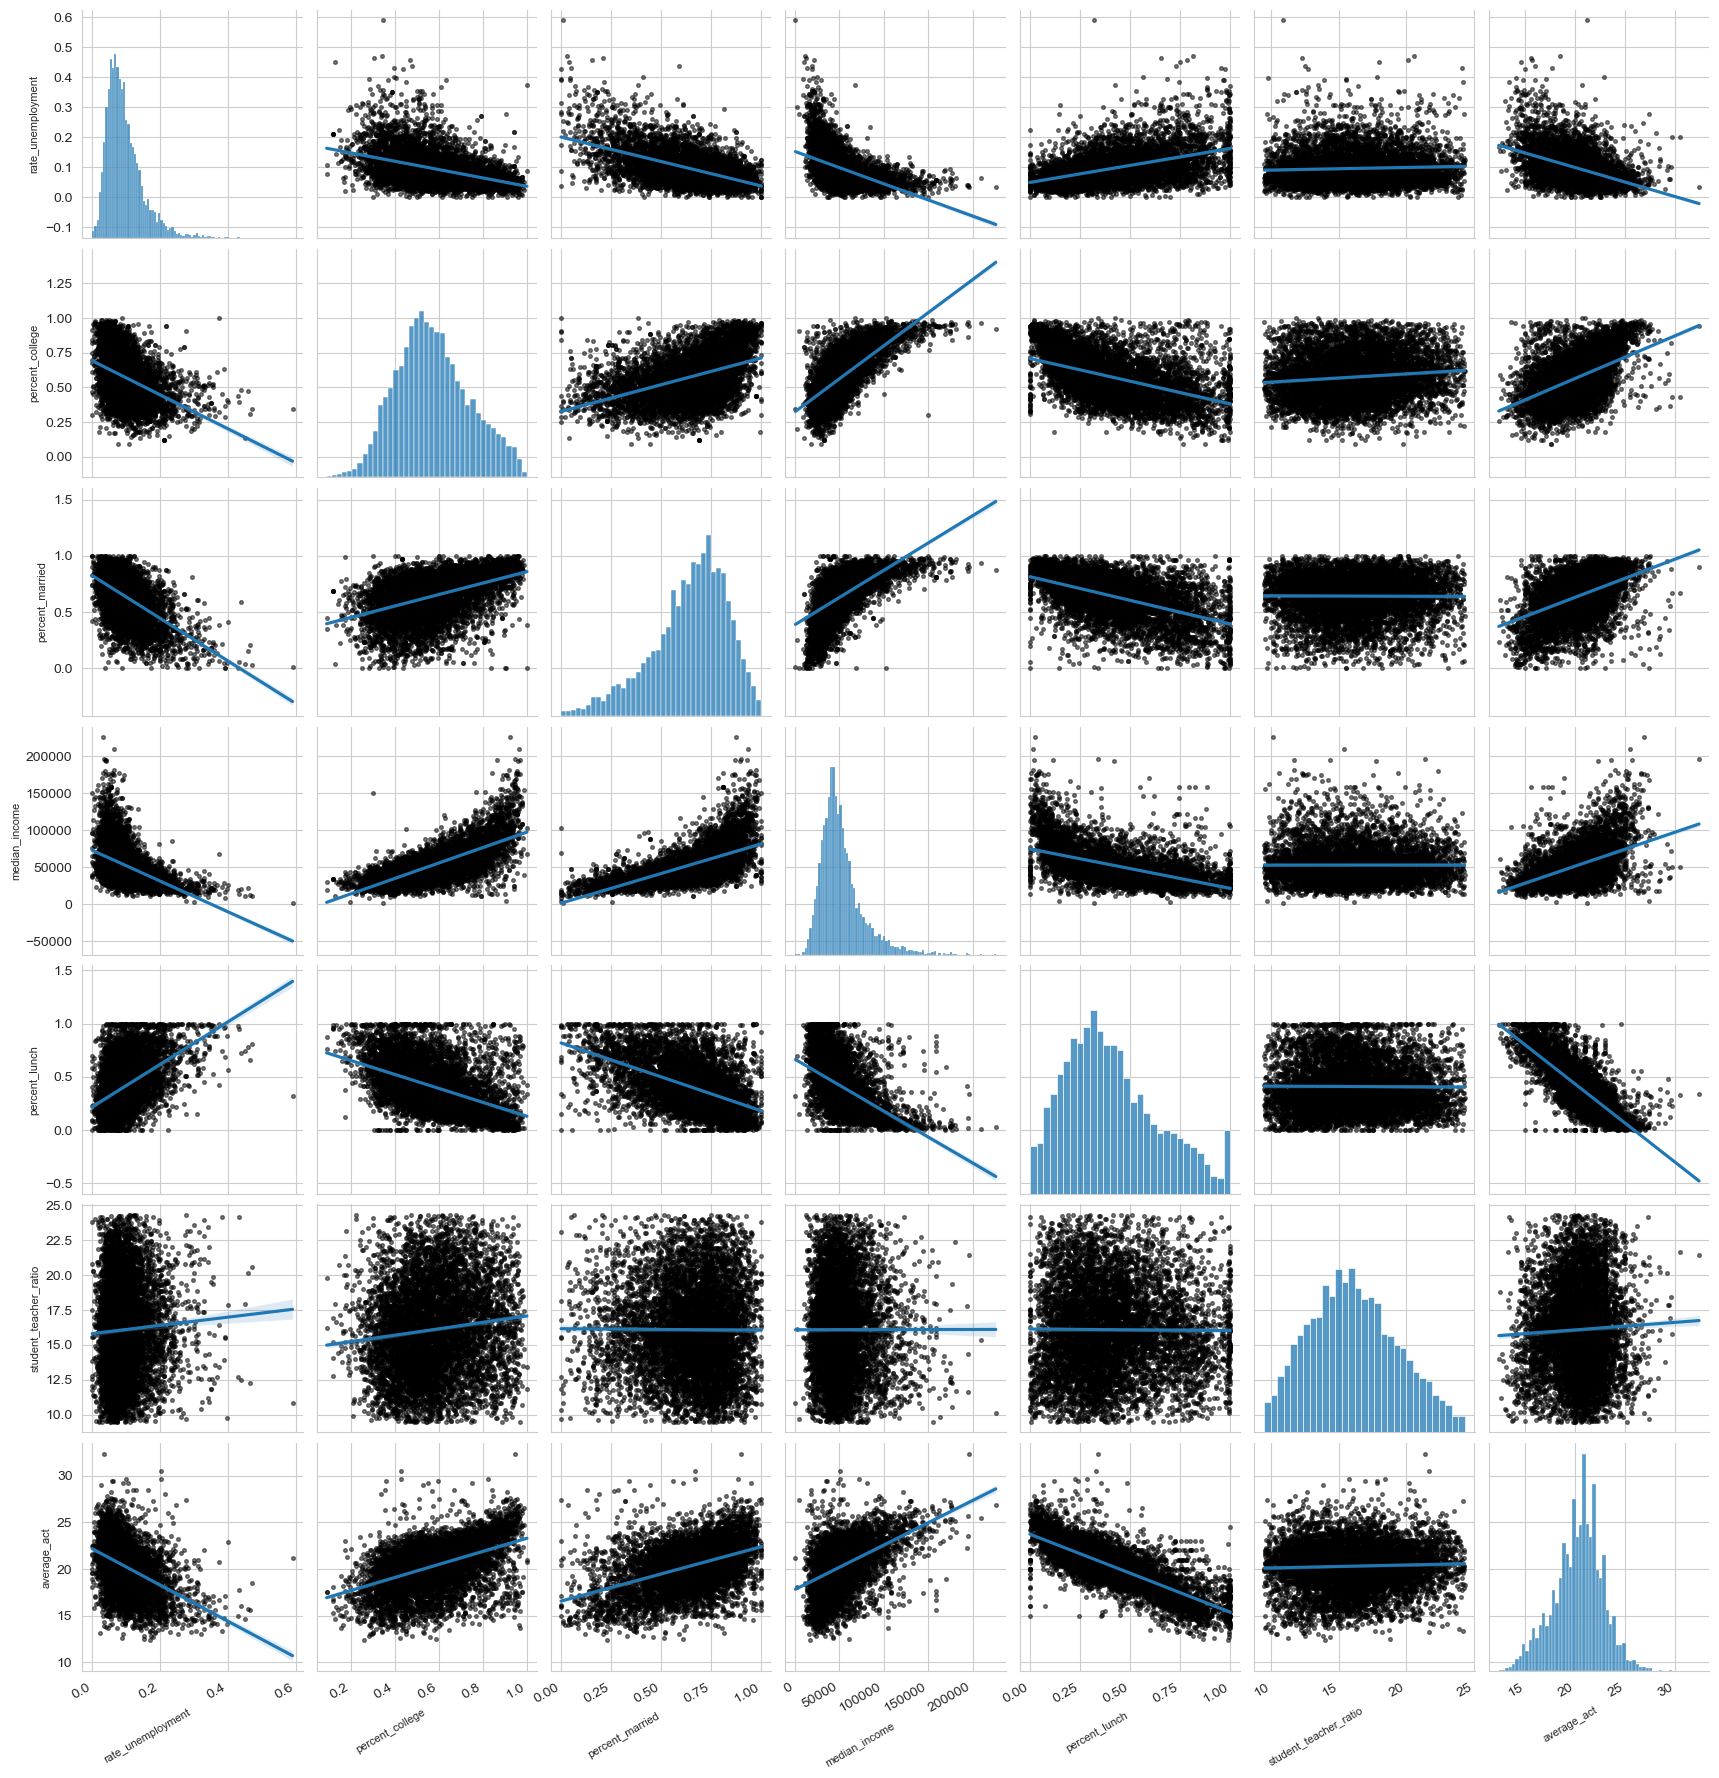

In [851]:
fig = sns.pairplot(
    data = df,
    vars = numerical_predictors + ['average_act'],
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7}
    }
)

for ax in fig.axes.flat: 
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  
        
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')  
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    
    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

**Summary:**
* The numerical predictors are related to average_act. The relationships appear roughly linear.
* The numerical predictors are correlated with each other, suggesting that not all predictors will be neccessary.

**Analysis:** Looking at the bottom row of the pair plots, student-teacher ratio shows weak associations with all variables. Interestingly, the relationship between student-teacher ratio and ACT score is weakly positive, which is counterintuitive—we might expect lower ratios to improve performance through more individualized attention.
This weak positive correlation likely reflects confounding factors. Schools in wealthier areas may have higher student-teacher ratios due to larger enrollments while still performing well due to access to more resources like test preparation. Additionally, the ratio may not accurately reflect actual classroom sizes since it includes all instructional staff.
Overall, the weak relationship suggests that student-teacher ratio alone is not a strong predictor of ACT performance compared to socioeconomic factors. In the modeling phase, we will assess whether student-teacher ratio contributes meaningfully to the multiple regression model.

## Modeling with linear regression

### Simple linear regression with student-teacher ratio

#### Plot the regression line and scatter plot

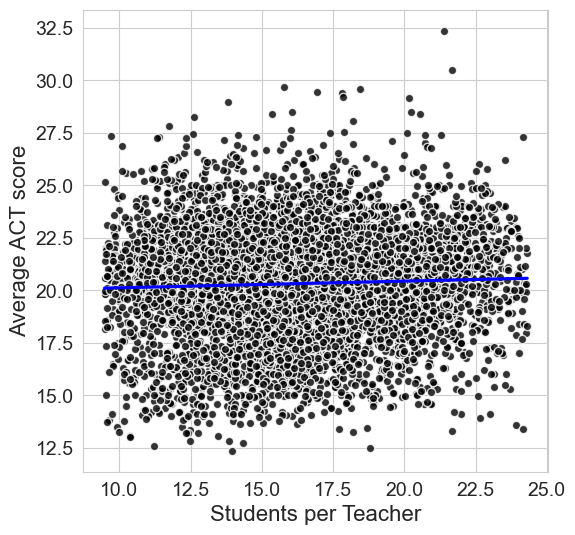

In [856]:
plt.figure(figsize=(6,6))

sns.regplot(data=df, 
            x = 'student_teacher_ratio',
            y='average_act',
            color='blue',
            ci=False, 
            scatter_kws={'color':'black', 'edgecolors':'white', 'linewidths':1})

# Add axel labels
plt.xlabel('Students per Teacher', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

**Analysis:** There is slight, positive association between student-teacher ratio and average ACT score. Let's take a look at the simple linear regression model.

##### Fit the simple linear regression model

In [893]:
model_st_ratio = smf.ols(formula='average_act ~ student_teacher_ratio', data=df).fit()

In [894]:
print(model_st_ratio.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     11.86
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           0.000575
Time:                        22:13:22   Log-Likelihood:                -16168.
No. Observations:                6941   AIC:                         3.234e+04
Df Residuals:                    6939   BIC:                         3.235e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                19.80

##### Compute the mean absolute error

In [895]:
mean_absolute_error(df['average_act'], model_st_ratio.predict())

1.9488080380206594

**Note:** The simple linear regression model with student-teacher ratio can predict ACT scores with an average error of roughly 2 points. 

**Analysis:** The R-squared value of 0.002 is very low indicating that it will not add much predictive insight to the model. This is unsuprising considering the weak association shown in the regression plot. The p-value is statistically significant meaning the relationship is not due to random chance, but that does not imply it will help the accuracy of the model. I suspect the low p-value is due to the large sample size so the relationship is statistcally significant but not in a practical sense. 

Since the R-squared is so low, I doubt undergoing transformation of any time on student-ratio will make a difference. Next, let's see if it adds _any_ improvement to a multiple linear regression model.

### Multiple Linear Regression

#### Perform multiple linear regression model with all predictors

In [862]:
model = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch+student_teacher_ratio',
    data=df).fit()

In [863]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     1978.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:06:30   Log-Likelihood:                -12712.
No. Observations:                6941   AIC:                         2.544e+04
Df Residuals:                    6934   BIC:                         2.549e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                22.35

**Note:** Percent married and median income produce p-values that are not statistcally significant. There was correlations among the predictors so we may not have to include all of them in the model.  

##### Use a residual plot for graphical assessment of model fit

In [864]:
y_hat = model.predict()

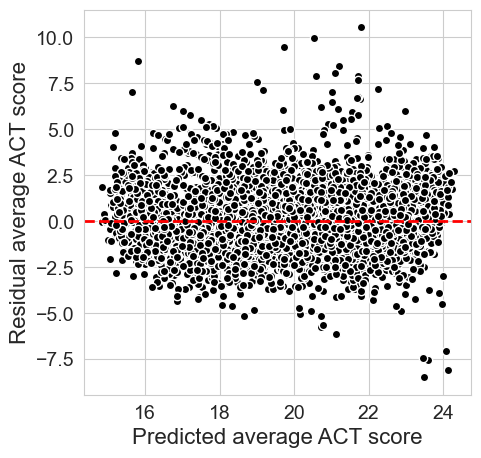

In [865]:
plt.figure(figsize=(5,5))

plt.plot(y_hat, model.resid, 'ko', mec = 'w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

**Note:** There is relatively no structure to the residual plot so transformations of the predictors are unlikely to help the model. 

##### Compute the mean absolute error

In [867]:
mean_absolute_error(df['average_act'], model.predict())

1.131465953321226

**Summary:** The multiple linear regression model with all socioeconmic predictors and student-teacher ratio can predict ACT scores with an average error of roughly 1 point using these predictors. The residual plots suggests that there will be limited improvement from adding trasnformations of these predictors.

#### Perform Multiple Linear Regression model with only statiscally significant predictors

In [868]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch+student_teacher_ratio',
    data=df).fit()

In [869]:
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2968.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:14:00   Log-Likelihood:                -12712.
No. Observations:                6941   AIC:                         2.543e+04
Df Residuals:                    6936   BIC:                         2.547e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                22.33

##### Compute the absolute mean error of the reduced model

In [871]:
mean_absolute_error(df['average_act'], model_reduced.predict())

1.1313828087410487

**Analysis:** The multiple linear regression model with all statistcally significant predictors can predict ACT scores with an average error of roughly 1 point using these predictors.

#### Compare the accuracy between the full and reduced models

In [872]:
mae_full = mean_absolute_error(df['average_act'], model.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r1_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced], 
              'R-squared': [r1_full, r2_reduced]}, 
             index = ['full model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
full model,1.1315,0.6312
reduced model,1.1314,0.6312


#### Use an ANOVA to test the significance of difference between models

In [875]:
anova_lm(model_reduced, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,6936.0,15838.133337,0.0,NaN,NaN,NaN
1,6934.0,15836.816405,2.0,1.316931,0.288303,0.749543


**Analysis:** Since the differences in mean absolute error and R-squared between the two models is negligible, it is unsurprising that the difference is not statistically significant. Next, we will perform a multiple linear regression without student-teacher ratio and compare it to the full and reduced model. 

#### Perform multiple linear regression model with all predictors except student-teacher ratio

In [889]:
model_full_ratio = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch',
    data=df).fit()

In [890]:
print(model_reduced_ratio.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     2368.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:54:20   Log-Likelihood:                -12718.
No. Observations:                6941   AIC:                         2.545e+04
Df Residuals:                    6935   BIC:                         2.549e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6130      0.13

#### Compare the accuracy between the full, reduced, and full exlcuding student-teacher ratio models

In [892]:
mae_full = mean_absolute_error(df['average_act'], model.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())
mae_full_ratio = mean_absolute_error(df['average_act'], model_full_ratio.predict())

r1_full = model.rsquared
r2_reduced = model_reduced.rsquared
r3_full_ratio = model_reduced_ratio.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced, mae_full_ratio], 
              'R-squared': [r1_full, r2_reduced, r3_full_ratio]}, 
             index = ['full model', 'reduced model','full model excl. S-T ratio']).round(4)

,Mean Absolute Error,R-squared
full model,1.1315,0.6312
reduced model,1.1314,0.6312
full model excl. S-T ratio,1.1324,0.6306


**Conclusion:** In comparing the three models, we can see that there is barely any difference between the full, reduced, and full excluding student-teacher ratio models. Even though the student-teacher ratio variable is statistically significant, it does not provide any predictive power to the model. In fact, the full model with the student-teacher ratio excluded has the highest mean absolute error, although not by a substantial amount. Therefore, the student-teacher ratio variable does not serve as a good predictor for predicting average ACT score among schools across the nation. 

To address the original question of whether we can predict a school's ACT performance based on our predictors, the answer is yes. Our models achieve this with an error of approximately one point. Given the range of possible ACT scores, all three models demonstrate a pretty high level of accuracy.